## Importing libraries

In [2]:
import pandas as pd
import numpy as np

# importing LabelEncoder
from sklearn.preprocessing import LabelEncoder

# importing regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression

# importing evaluting metrics
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score

# importing helpers for modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict

# importing time
import time

# importing visualization packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# ingnoring the warnings
import warnings
warnings.filterwarnings('ignore')

## Data Accessing

In [4]:
df_flights=pd.read_csv(r'C:\Users\pavan\OneDrive\Desktop\Data Mining\Project\Flights.csv')

## EDA

In [5]:
df_flights.shape

(300153, 12)

In [6]:
# displaying first 5 rows of data
df_flights.head().style.hide_index()

Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.170000,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.330000,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.170000,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.250000,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.330000,1,5955


In [7]:
# displaying last 5 rows of data
df_flights.tail().style.hide_index()

Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.080000,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.420000,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.830000,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.000000,49,81585
300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.080000,49,81585


In [8]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


<font size = "3"> All the column names except the first one are readable. So, we don't have to rename the columns </font>

In [102]:
# dispalying the statistical data of the attributes
df_flights.describe()

,stops,duration,days_left,price
count,300142.000000,300142.000000,300142.000000,300142.000000
mean,0.945459,12.221121,26.005011,20889.666075
std,0.482653,7.192015,13.560779,22697.230298
min,0.000000,0.830000,1.000000,1105.000000
25%,1.000000,6.830000,15.000000,4783.000000
50%,1.000000,11.250000,26.000000,7425.000000
75%,1.000000,16.170000,38.000000,42521.000000
max,4.000000,49.830000,49.000000,117307.000000


### Checking for null and duplicate values

In [103]:
df_flights.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [12]:
df_flights[df_flights.duplicated()]

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price


### Scatterplot to identify outliers

<AxesSubplot:xlabel='airline', ylabel='price'>

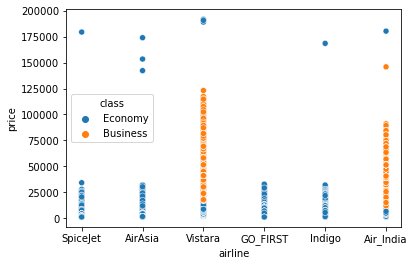

In [13]:
sns.scatterplot(data=df_flights,x='airline',y='price',hue='class')

### Data Visualization

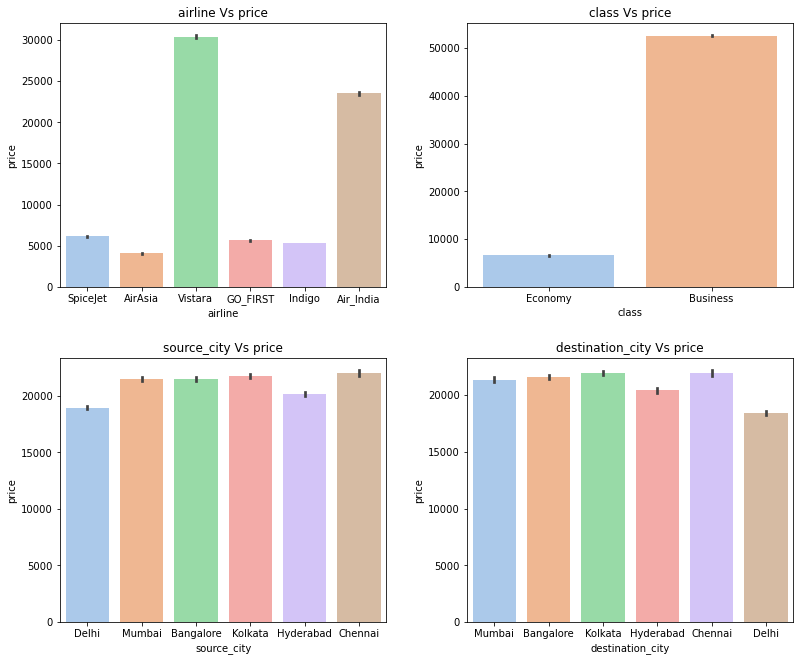

In [30]:
# Visualizing the relationship between price and categorical attributes
fig, ax = plt.subplots(2, 2, figsize=(12,10))
fig.tight_layout()
fig.tight_layout(pad=5.0)

def barplots(attributes):
    i=1
    for n,att in enumerate(attributes):
        plt.subplot(2,2,i)
        plt.title(str(att) + ' Vs ' + 'price')
        sns.barplot(x=att, y = 'price', data = df_flights,palette='pastel')
        i+=1

barplots(['airline','class','source_city','destination_city'])

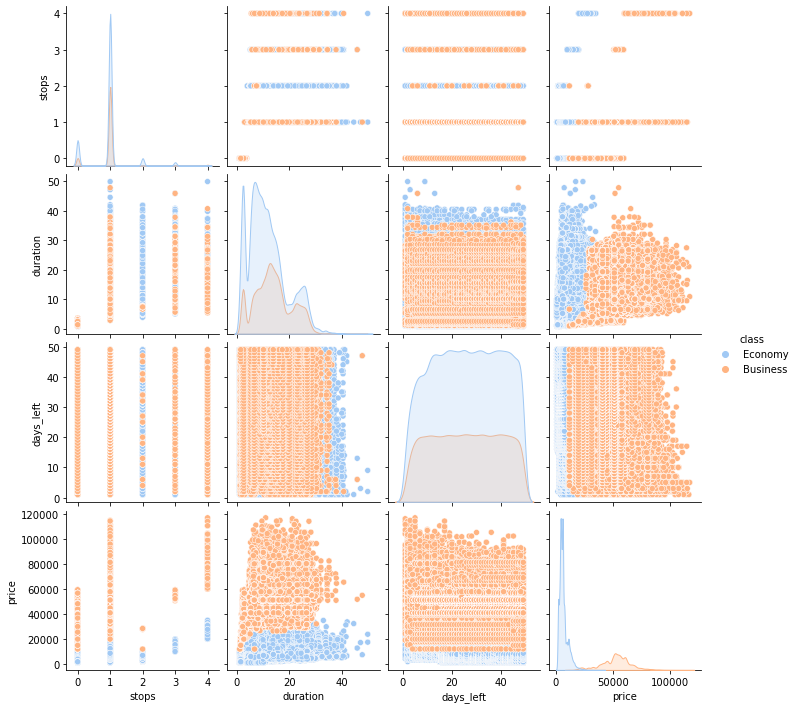

In [39]:
sns.pairplot(df_flights,hue='class',palette='pastel')

## Data Cleaning

### Dropping unnecessary column
<font size = "3"> The first column is unnamed and doesn't add any value for our analysis. So, dropping that column </font>

In [9]:
df_flights.drop('Unnamed: 0',axis=1,inplace=True)

### Dropping the outliers

In [14]:
Q1 = np.percentile(df_flights['price'],25,interpolation = 'midpoint')
Q3 = np.percentile(df_flights['price'],75,interpolation = 'midpoint')

IQR = Q3 - Q1
 
print("Old Shape: ", df_flights.shape)
 
# Upper bound
upper = np.where(df_flights['price'] >= (Q3+2.1*IQR))
# Lower bound
lower = np.where(df_flights['price'] <= (Q1-1.6*IQR))
 
# Removing the Outliers
df_flights.drop(upper[0], inplace = True)
df_flights.drop(lower[0], inplace = True)
 
print("New Shape: ", df_flights.shape)

Old Shape:  (300153, 11)
New Shape:  (300142, 11)


<AxesSubplot:xlabel='airline', ylabel='price'>

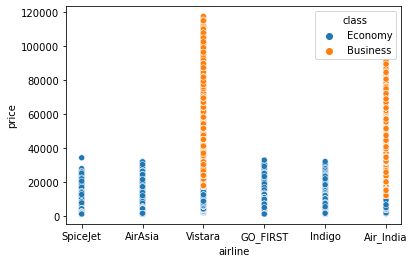

In [15]:
sns.scatterplot(data=df_flights,x='airline',y='price',hue='class')

<font size ="3">The unnamed column and outliers are redundant for our analysis.</font>
<font size ="3">The dataset is clean after dropping the unnamed column and outliers. Also, there aren't any null values or duplicates in the dataset</font>

### Modifying the 'stops' column

In [16]:
# Converting numeric word values to numeric digits in 'stops' column
# to show its correlation with other attributes.

f_stops = df_flights["stops"].values
f_price = df_flights["price"].values
f_class = df_flights["class"].values

for i in range(len(f_stops)):
    if f_stops[i] == "zero":
        f_stops[i] = 0
    elif f_stops[i] == "one":
        f_stops[i] = 1
    elif f_stops[i] == "two_or_more":
        if f_class[i]=="Economy":
            if f_price[i] >= 1966 and f_price[i] < 10000:
                f_stops[i] = 2
            elif f_price[i] >= 10000 and f_price[i] < 20000:
                f_stops[i] = 3
            elif f_price[i] >= 20000 and f_price[i] < 36000:
                f_stops[i] = 4
        else:
            if f_price[i] >= 12000 and f_price[i] < 35000:
                f_stops[i] = 2
            elif f_price[i] >= 35000 and f_price[i] < 60000:
                f_stops[i] = 3
            elif f_price[i] >= 60000 and f_price[i] < 118000:
                f_stops[i] = 4

In [17]:
df_flights["stops"]=f_stops

In [18]:
df_flights.tail().style.hide_index()

airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
Vistara,UK-822,Chennai,Morning,1,Evening,Hyderabad,Business,10.080000,49,69265
Vistara,UK-826,Chennai,Afternoon,1,Night,Hyderabad,Business,10.420000,49,77105
Vistara,UK-832,Chennai,Early_Morning,1,Night,Hyderabad,Business,13.830000,49,79099
Vistara,UK-828,Chennai,Early_Morning,1,Evening,Hyderabad,Business,10.000000,49,81585
Vistara,UK-822,Chennai,Morning,1,Evening,Hyderabad,Business,10.080000,49,81585


In [19]:
df_flights[['stops']] = df_flights[['stops']].apply(pd.to_numeric) 

### Label Encoder

In [49]:
# making a copy of the dataset
df = df_flights.copy()

encd=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=encd.fit_transform(df[col])

## Correlation

<AxesSubplot:>

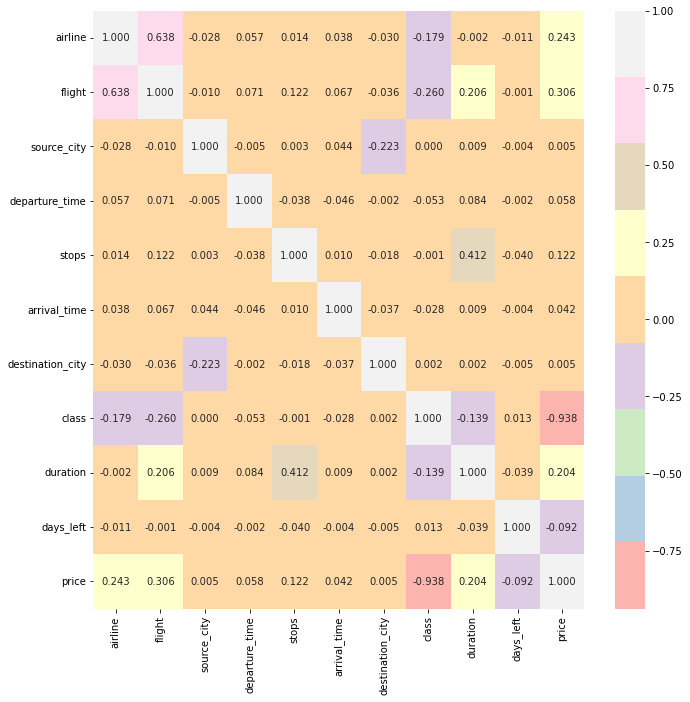

In [62]:
plt.figure(figsize=(11,11))
sns.heatmap(df.corr(), cbar=True, annot=True, fmt='.3f', cmap="Pastel1")

## Histogram

array([[<AxesSubplot:title={'center':'stops'}>,
        <AxesSubplot:title={'center':'duration'}>],
       [<AxesSubplot:title={'center':'days_left'}>,
        <AxesSubplot:title={'center':'price'}>]], dtype=object)

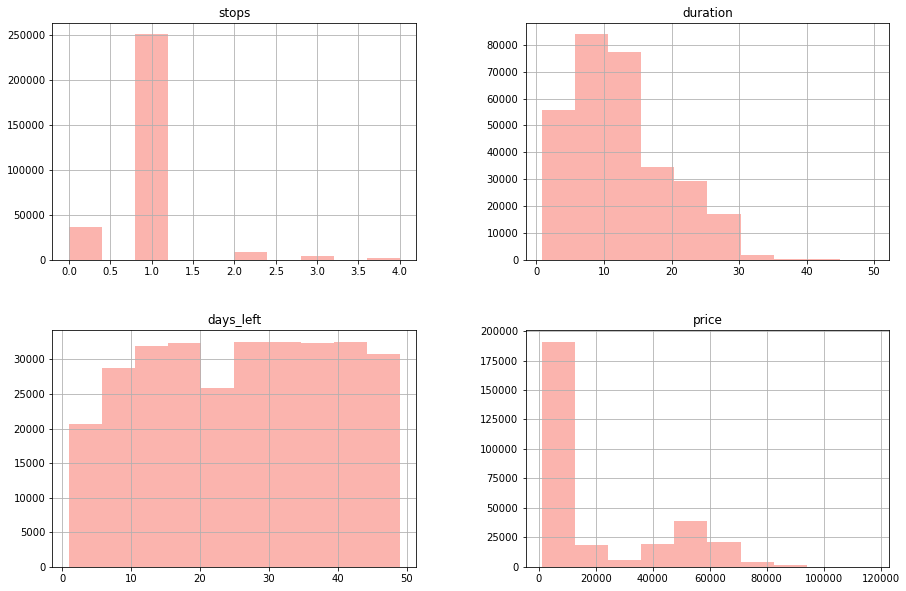

In [21]:
fig_size=plt.figure(figsize=(15,10))
hist1=fig_size.gca()
df_flights.hist(ax=hist1,color='#fbb4ae')

## Modeling

In [45]:
models = ['Random Forest Regression', 'Linear Regression', 'Bagging Regression']
train_r2 = []
test_r2 = []
train_rmse = []
test_rmse =[]

### Data Splitting and Training

In [46]:
X=df.drop(['price'],axis=1)
y=df['price']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333)

### Random Forest Regression

In [48]:
# Training the model
model_rf=RandomForestRegressor()
start_time = time.time()
model_rf = model_rf.fit(X_train,y_train)
end_time = time.time()

In [63]:
print('****** Random Forest Regression model: ******')
print(f'Time taken to fit Random Forest Regressor model: {round(end_time - start_time, 2)} seconds')

kf=KFold(shuffle=True, n_splits=5)

y_train_pred_rf = model_rf.predict(X_train)
y_test_pred_rf = model_rf.predict(X_test)

# Calculating r2 score for training data
rf_train_r2 = np.mean(cross_val_score(model_rf, X_train, y_train, cv=kf, scoring='r2'))
rf_train_rmse = mean_squared_error(y_train, y_train_pred_rf)**0.5

print('\nTraining Details:')
print('\nR2 score: ',rf_train_r2)
print('\nMSE: ',rf_train_rmse)

# Calculating r2 score for testing data
rf_test_r2 = np.mean(cross_val_score(model_rf, X_test, y_test, cv=kf, scoring='r2'))
rf_test_rmse = mean_squared_error(y_test, y_test_pred_rf)**0.5

print('\nTesting Details:')
print('\nR2 score: ',rf_test_r2)
print('\nMSE: ',rf_test_rmse)

train_r2.append(rf_train_r2)
test_r2.append(rf_test_r2)
train_rmse.append(rf_train_rmse)
test_rmse.append(rf_test_rmse)

****** Random Forest Regression model: ******
Time taken to fit Random Forest Regressor model: 133.79 seconds

Training Details:

R2 score:  0.9885189218437169

MSE:  894.9340608024323

Testing Details:

R2 score:  0.9865995043342751

MSE:  2336.642827141172


### Linear Regression

In [64]:
# Training the model
model_lr=LinearRegression()
start_time = time.time()
model_lr=model_lr.fit(X_train,y_train)
end_time = time.time()

In [65]:
print('\n****** Linear Regression model: ******')
print(f'Time taken to fit Linear Regression model: {round(end_time - start_time, 2)} seconds')

y_train_pred_lr = model_lr.predict(X_train)
y_test_pred_lr = model_lr.predict(X_test)

# Calculating r2 score for training data
lr_train_r2 = np.mean(cross_val_score(model_lr, X_train, y_train, cv=kf, scoring='r2'))
lr_train_rmse = mean_squared_error(y_train, y_train_pred_lr)**0.5

print('\nTraining Details:')
print('\nR2 score: ',lr_train_r2)
print('\nMSE: ',lr_train_rmse)

# Calculating r2 score for testing data
lr_test_r2 = np.mean(cross_val_score(model_lr, X_test, y_test, cv=kf, scoring='r2'))
lr_test_rmse = mean_squared_error(y_test, y_test_pred_lr)**0.5

print('\nTesting Details:')
print('\nR2 score: ',lr_test_r2)
print('\nMSE: ',lr_test_rmse)

train_r2.append(lr_train_r2)
test_r2.append(lr_test_r2)
train_rmse.append(lr_train_rmse)
test_rmse.append(lr_test_rmse)


****** Linear Regression model: ******
Time taken to fit Linear Regression model: 0.07 seconds

Training Details:

R2 score:  0.9067486502089622

MSE:  6931.158116373983

Testing Details:

R2 score:  0.9064346758101495

MSE:  6941.09879023015


### Bagging Regression

In [66]:
# Training the model
model_bg=BaggingRegressor()
start_time = time.time()
model_bg=model_bg.fit(X_train,y_train)
end_time = time.time()

In [67]:
print('\n****** Bagging Regression model: ******')
print(f'Time taken to fit Bagging Regression model: {round(end_time - start_time, 2)} seconds')

y_train_pred_bg = model_bg.predict(X_train)
y_test_pred_bg = model_bg.predict(X_test)

# Calculating r2 score for training data
bg_train_r2 = np.mean(cross_val_score(model_bg, X_train, y_train, cv=kf, scoring='r2'))
bg_train_rmse = mean_squared_error(y_train, y_train_pred_bg)**0.5

print('\nTraining Details:')
print('\nR2 score: ',bg_train_r2)
print('\nMSE: ',bg_train_rmse)

# Calculating r2 score for testing data
bg_test_r2 = np.mean(cross_val_score(model_bg, X_test, y_test, cv=kf, scoring='r2'))
bg_test_rmse = mean_squared_error(y_test, y_test_pred_bg)**0.5

print('\nTesting Details:')
print('\nR2 score: ',bg_test_r2)
print('\nMSE: ',bg_test_rmse)

train_r2.append(bg_train_r2)
test_r2.append(bg_test_r2)
train_rmse.append(bg_train_rmse)
test_rmse.append(bg_test_rmse)


****** Bagging Regression model: ******
Time taken to fit Bagging Regression model: 14.12 seconds

Training Details:

R2 score:  0.987559095407882

MSE:  1049.3081179280184

Testing Details:

R2 score:  0.9855163872189315

MSE:  2424.548685626636


## Comparing R2 score of all the models

In [68]:
r2_compare = pd.DataFrame({'Model' : models, 'Training_R2_Score' : train_r2, 'Testing_R2_Score' : test_r2,'Training_RMSE' : train_rmse, 'Testing_RMSE' : test_rmse})
r2_compare.sort_values(by='Testing_R2_Score', ascending=False)

,Model,Training_R2_Score,Testing_R2_Score,Training_RMSE,Testing_RMSE
0,Random Forest Regression,0.988519,0.986600,894.934061,2336.642827
2,Bagging Regression,0.987559,0.985516,1049.308118,2424.548686
1,Linear Regression,0.906749,0.906435,6931.158116,6941.098790


[Text(0, 0, 'Random Forest Regression'),
 Text(1, 0, 'Linear Regression'),
 Text(2, 0, 'Bagging Regression')]

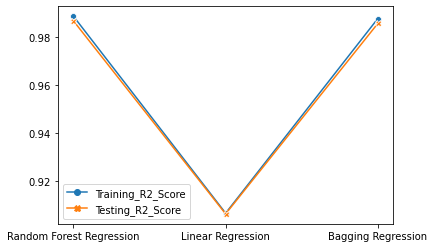

In [70]:
# Visualizing the training and the testing R2 Scores of all the models
ax = sns.lineplot(data=[r2_compare['Training_R2_Score'], r2_compare['Testing_R2_Score']], dashes=False, markers=True)
ax.set_xticks(range(len(r2_compare['Model'])))
ax.set_xticklabels(r2_compare['Model'])

[Text(0, 0, 'Random Forest Regression'),
 Text(1, 0, 'Linear Regression'),
 Text(2, 0, 'Bagging Regression')]

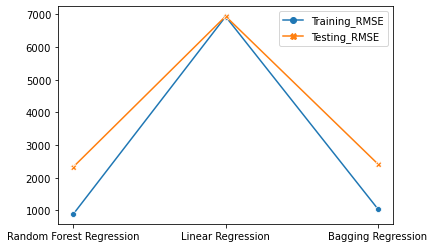

In [72]:
# Visualizing the training and the testing RMSE of all the models
ax = sns.lineplot(data=[r2_compare['Training_RMSE'], r2_compare['Testing_RMSE']], dashes=False, markers=True)
ax.set_xticks(range(len(r2_compare['Model'])))
ax.set_xticklabels(r2_compare['Model'])

## Hyperparameter Tuning

In [134]:
r2_list = []
rmse_list = []

r2_list.append(rf_test_r2)
rmse_list.append(rf_test_rmse)

# RF with 125 estimators and 10 features
rf_10_125 = RandomForestRegressor(bootstrap=True, max_features=10, n_estimators=125)
rf_10_125 = rf_10_125.fit(X_train, y_train)

test_predictions = rf_10_125.predict(X_test)
r2 = r2_score(y_test, test_predictions)
rmse = mean_squared_error(y_test, test_predictions)**0.5

print('\n****** Random Forest Regression model: 125 Estimators and 10 features******')
print('Tuned R2 score: ',r2)
print('Tuned MSE: ',rmse)
 
r2_list.append(r2)
rmse_list.append(rmse)


****** Random Forest Regression model: 125 Estimators and 10 features******
Tuned R2 score:  0.9894721244180045
Tuned MSE:  2328.5337573524694


In [135]:
# RF with 75 estimators and 8 features
rf_8_75 = RandomForestRegressor(bootstrap=True, max_features=8, n_estimators=75)
rf_8_75 = rf_8_75.fit(X_train, y_train)

test_predictions = rf_8_75.predict(X_test)
r2 = r2_score(y_test, test_predictions)
rmse = mean_squared_error(y_test, test_predictions)**0.5

print('\n****** Random Forest Regression model: 75 Estimators and 8 features******')
print('Tuned R2 score: ',r2)
print('Tuned MSE: ',rmse)

r2_list.append(r2)
rmse_list.append(rmse)


****** Random Forest Regression model: 75 Estimators and 8 features******
Tuned R2 score:  0.9890225975958079
Tuned MSE:  2377.7268325455484


### Comparing Random Forest Regression models with different estimators and features

In [139]:
rf_models = ['Random Forest Regression', 'RF(E:125, F:10)', 'RF(E:75, F:8)']
r2_compare = pd.DataFrame({'Model' : rf_models, 'R2 Score' : r2_list, 'RMSE' : rmse_list})
r2_compare.sort_values(by='R2 Score', ascending=False)

,Model,R2 Score,RMSE
1,"RF(E:125, F:10)",0.989472,2328.533757
2,"RF(E:75, F:8)",0.989023,2377.726833
0,Random Forest Regression,0.986600,2336.642827


[Text(0, 0, 'Random Forest Regression'),
 Text(1, 0, 'RF(E:125, F:10)'),
 Text(2, 0, 'RF(E:75, F:8)')]

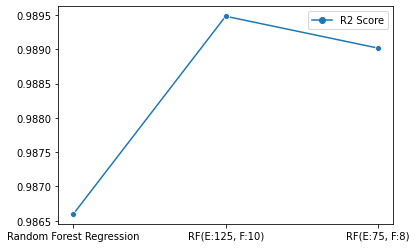

In [127]:
# Visualizing the R2 Scores of all the models
ax = sns.lineplot(data=[r2_compare['R2 Score']], dashes=False, markers=True)
ax.set_xticks(range(len(r2_compare['Model'])))
ax.set_xticklabels(r2_compare['Model'])

[Text(0, 0, 'Random Forest Regression'),
 Text(1, 0, 'RF(E:125, F:10)'),
 Text(2, 0, 'RF(E:75, F:8)')]

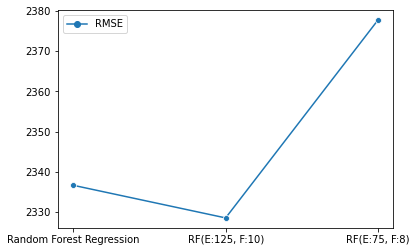

In [140]:
# Visualizing the RMSE Scores of all the models
ax = sns.lineplot(data=[r2_compare['RMSE']], dashes=False, markers=True)
ax.set_xticks(range(len(r2_compare['Model'])))
ax.set_xticklabels(r2_compare['Model'])

## Price Prediction

In [85]:
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

In [89]:
pred_price=pd.DataFrame({'Actual Price':y_test,'Predicted Price':y_pred})
df_predict=df2.merge(pred_price,left_index=True,right_index=True)

In [90]:
df_predict.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Actual Price,Predicted Price
243766,Vistara,UK-940,Mumbai,Evening,1,Morning,Chennai,Business,14.17,33,64173,64173,65286.28
59253,Air_India,AI-809,Mumbai,Morning,1,Evening,Bangalore,Economy,6.25,37,6082,6082,6480.44
258954,Vistara,UK-810,Bangalore,Early_Morning,1,Evening,Hyderabad,Business,10.00,49,56588,56588,56588.00
80925,Vistara,UK-851,Mumbai,Early_Morning,2,Evening,Chennai,Economy,9.33,27,8445,8445,8158.35
24001,GO_FIRST,G8-334,Delhi,Early_Morning,1,Evening,Kolkata,Economy,9.50,23,6395,6395,6395.00
278086,Vistara,UK-880,Hyderabad,Afternoon,1,Night,Mumbai,Business,7.83,15,60555,60555,60735.00
233758,Vistara,UK-996,Mumbai,Evening,1,Morning,Bangalore,Business,17.33,44,69168,69168,70191.93
165858,Vistara,UK-860,Hyderabad,Early_Morning,1,Night,Bangalore,Economy,16.50,5,15268,15268,14945.68
18609,GO_FIRST,G8-101,Delhi,Early_Morning,1,Afternoon,Bangalore,Economy,6.83,42,6832,6832,6781.22
130271,GO_FIRST,G8-537,Kolkata,Evening,1,Night,Mumbai,Economy,5.00,19,7958,7958,8717.80


In [133]:
# plt.figure(figsize=(5,5))
# sns.regplot(x='Actual Price',y='Predicted Price',data=df_predict,color='#fbb4ae')
# plt.title('Actual Price  Vs  Predicted Price ',fontsize=20)
# plt.xlabel('Actual Price',fontsize=15)
# plt.ylabel('Predicted Price',fontsize=15)
# plt.show()

## Feature Importance

In [101]:
imp_list = list(model_rf.feature_importances_)
attributes = X_train.columns
imp_list = [round(imp,2) for imp in imp_list]
feature_imp = pd.DataFrame({'Feature' : attributes, 'Importance' : imp_list})
feature_imp.sort_values(by='Importance', ascending=False, inplace=True)
feature_imp

,Feature,Importance
7,class,0.88
8,duration,0.05
1,flight,0.03
9,days_left,0.02
2,source_city,0.01
6,destination_city,0.01
0,airline,0.00
3,departure_time,0.00
4,stops,0.00
5,arrival_time,0.00


In [93]:
# model_rf.fit(X_train, y_train)
# rf_input=df2[1]
# #[['SpiceJet','SG-8709','Delhi','Evening','zero','Night','Mumbai','Economy',2.17,1,5953]]
# predicted_price=model_rf.predict(rf_input)
# print(rf_input, predicted_price)